In [1]:
import osmnx as ox
import sqlite3
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import math
import seaborn as sns
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import psycopg2
from geopandas.tools import sjoin
from shapely.geometry import Point, LineString, Polygon

import warnings
warnings.filterwarnings("ignore")

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-spzf7n3l because the default path (/home/jverdan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
df = pd.read_csv('data_mmda_traffic_spatial.csv')

df_map = df.copy()
imap = folium.Map(location=[14.6091, 121.0223], tiles='openstreetmap', zoom_start=12)

mc = MarkerCluster()

for idx, row in df_map.iterrows():
    if not math.isnan(row['Longitude']) and not math.isnan(row['Latitude']):
        mc.add_child(Marker([row['Latitude'], row['Longitude']]))

imap.add_child(mc)
imap

In [3]:
# Insert details here
conn = psycopg2.connect(dbname="postgis", 
                 user="xxxx", 
                 password="xxxxx", 
                 host="xxx", 
                 port=0000)

In [4]:
# Check contents of ph_point

q = '''
SELECT *
FROM ph_point
'''

df_pt = pd.read_sql(q, conn)

# Check the contents of gadm.ph
q = '''
SELECT *
FROM gadm.ph_brgy
LIMIT 100
'''

df_gadm = pd.read_sql(q, conn)

In [5]:
cols = ['Date', 'Time', 'Country', 'City', 'Location', 'Latitude', 'Longitude',
        'Direction', 'Type', 'Involved']

cols = ['Date', 'Country', 'City', 'Location', 'Latitude', 'Longitude']

df_accident = df[cols]
df_accident = df_accident.loc[df_accident.Latitude != 0]
df_accident['Location'] = df_accident['Location'].fillna('TBD')
x = df_accident.loc[df_accident.City.isna()].loc[df_accident.Location.str.contains('MABINI')].index
df_accident.loc[x] = df_accident.loc[x].fillna('Pasig City')
x = df_accident.loc[df_accident.City.isna()].loc[df_accident.Location.str.contains('MARCOS HIGHWAY')].index
df_accident.loc[x] = df_accident.loc[x].fillna('Pasig City')
x = df_accident.loc[df_accident.City.isna()].loc[df_accident.Location.str.contains('OKADA')].index
df_accident.loc[x] = df_accident.loc[x].fillna('Pasay City')
df_accident.City = df_accident.City.fillna('Manila')
df_accident.replace({'ParaÃ±aque':'Parañaque'}, inplace=True)

gdf = gpd.GeoDataFrame(df_accident, geometry=gpd.points_from_xy(df_accident.Longitude, df_accident.Latitude))

In [6]:
ph_shp = gpd.read_postgis('''
SELECT *
from gadm.ph
''',con=conn,geom_col = 'geom')

In [7]:
mm_pts = gpd.read_postgis('''
SELECT p.*
FROM ph_point as p
JOIN gadm.ph as g ON st_within(p.way, g.geom)
WHERE p.amenity != 'None' AND g.name_1 = 'Metropolitan Manila'
''', con = conn, geom_col = 'way')

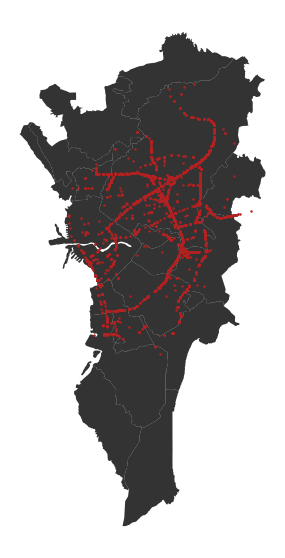

In [8]:
mm_shp = ph_shp[ph_shp['name_1']=='Metropolitan Manila']
ax = mm_shp.plot(figsize = (10,10), alpha=0.8, color='black')
gdf.plot(ax=ax,color='firebrick',markersize=2)
ax.set_axis_off()

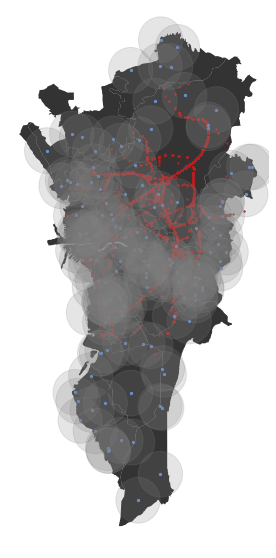

In [9]:
radius = 0.02

q = '''
SELECT g.name_2, p.amenity, p.name, p.way
FROM ph_point as p
JOIN gadm.ph_brgy as g ON st_within(p.way, g.geom)
WHERE p.amenity ~* 'police' AND p.name IS NOT NULL AND g.name_1 = 'Metropolitan Manila'
'''

police = gpd.read_postgis(q, con=conn, geom_col='way')

ncr_shp = gpd.read_postgis(
'''
SELECT *
FROM gadm.ph
WHERE name_1 = 'Metropolitan Manila'
'''
,con = conn, geom_col ='geom'
)

ncr = ncr_shp[['name_2', 'geom']]

# pointInPolys2 = sjoin(gdf, ncr, how='left')
# gdf2 = pointInPolys2.dropna()

fig, ax = plt.subplots(figsize=(10, 10))
ncr.plot(ax=ax, alpha=0.8, color='black')
gdf.plot(ax=ax,color='firebrick',markersize=2)
police.plot(ax=ax,color='cornflowerblue',markersize=5)
for i in police.index:
    cx = police.loc[i]['way'].xy[0][0]
    cy = police.loc[i]['way'].xy[1][0]
    circle = plt.Circle((cx, cy), radius, alpha=0.2, color='gray')
    ax.add_patch(circle)
ax.set_axis_off()

plt.show()

police1 = police.copy()
police1['way'] = police1['way'].buffer(radius)
gdf_ncr = gdf.copy()

police2 = police1.copy()
count_list = []
for i in police1.index:
    point = sjoin(gdf_ncr, police1.loc[[i]], how='left')
    count = point.dropna().shape[0]
    count_list.append(count)
police2['accident_count'] = count_list

In [10]:
police.shape

(149, 4)

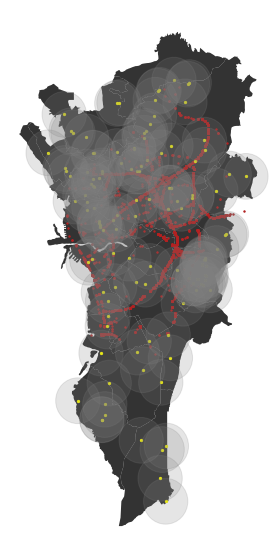

In [11]:
radius = 0.02

q = '''
SELECT g.name_2, p.amenity, p.name, p.way
FROM ph_point as p
JOIN gadm.ph_brgy as g ON st_within(p.way, g.geom)
WHERE p.amenity ~* 'hospital' AND p.name IS NOT NULL AND g.name_1 = 'Metropolitan Manila'
'''

hospital = gpd.read_postgis(q, con=conn, geom_col='way')

fig, ax = plt.subplots(figsize=(10, 10))
ncr.plot(ax=ax, alpha=0.8, color='black')
gdf.plot(ax=ax,color='firebrick',markersize=2)
hospital.plot(ax=ax,color='yellow',markersize=5)
for i in hospital.index:
    cx = hospital.loc[i]['way'].xy[0][0]
    cy = hospital.loc[i]['way'].xy[1][0]
    circle = plt.Circle((cx, cy), radius, alpha=0.2, color='gray')
    ax.add_patch(circle)
ax.set_axis_off()

plt.show()

hospital1 = hospital.copy()
hospital1['way'] = hospital1['way'].buffer(radius)
gdf_ncr = gdf.copy()

hospital2 = hospital1.copy()
count_list = []
for i in hospital1.index:
    point = sjoin(gdf_ncr, hospital1.loc[[i]], how='left')
    count = point.dropna().shape[0]
    count_list.append(count)
hospital2['accident_count'] = count_list

## Quezon City

### Police

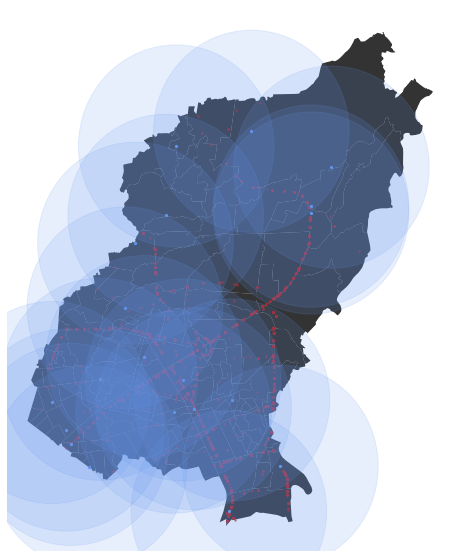

In [12]:
# Check which coverage will cover all accidents
radius = 0.035

q = '''
SELECT g.name_2, p.amenity, p.name, p.way
FROM ph_point as p
JOIN gadm.ph_brgy as g ON st_within(p.way, g.geom)
WHERE p.amenity ~* 'police' AND p.name IS NOT NULL AND g.name_2 = 'Quezon City'
'''

police_qc = gpd.read_postgis(q, con=conn, geom_col='way')

qc_shp = gpd.read_postgis(
'''
SELECT *
FROM gadm.ph_brgy
WHERE name_2 = 'Quezon City'
'''
,con = conn, geom_col ='geom'
)

qc = qc_shp[['name_2', 'name_3', 'geom']]
qc

pointInPolys2 = sjoin(gdf, qc, how='left')
gdf_qc = pointInPolys2.dropna()

fig, ax = plt.subplots(figsize=(10, 10))
qc.plot(ax=ax, alpha=0.8, color='black')
gdf_qc.plot(ax=ax,color='firebrick',markersize=2, alpha=0.6)
police_qc.plot(ax=ax,color='cornflowerblue',markersize=5)
for i in police_qc.index:
    cx = police_qc.loc[i]['way'].xy[0][0]
    cy = police_qc.loc[i]['way'].xy[1][0]
    circle = plt.Circle((cx, cy), radius, alpha=0.15, color='cornflowerblue')
    ax.add_patch(circle)
ax.set_axis_off()

plt.show()

In [13]:
# gdf_qc2 = gdf_qc.copy()

# for i in police_qc.index:
#     point = sjoin(gdf_qc, police_qc.loc[[i]], how='left')
#     count = point.dropna()
#     mask = gdf_qc2[gdf_qc2.index.isin(count.index)].index
#     gdf_qc2 = gdf_qc2.drop(index=mask)

# fig, ax = plt.subplots(figsize=(10, 10))
# qc.plot(ax=ax, alpha=0.8, color='black')
# gdf_qc2.plot(ax=ax, color='firebrick', markersize=2)
# ax.set_axis_off()
# plt.show()

ValueError: 'index_left' and 'index_right' cannot be names in the frames being joined

In [14]:
police_qc1 = police_qc.copy()
police_qc1['way'] = police_qc1['way'].buffer(radius)
gdf_qc1 = gdf.loc[gdf.City == 'Quezon City']
police_qc2 = police_qc1.copy()

count_list = []
for i in police_qc2.index:
    point = sjoin(gdf_qc1, police_qc2.loc[[i]], how='left')
    count = point.dropna().shape[0]
    count_list.append(count)
police_qc2['accident_count'] = count_list
police_qc2

name_2 amenity                                   name  \
0   Quezon City  police    La Loma Police Community Precinct 3   
1   Quezon City  police          Quezon City Police Station 12   
2   Quezon City  police  Quezon City Police Community Precinct   
3   Quezon City  police                                Outpost   
4   Quezon City  police                       Task Force Commo   
5   Quezon City  police           Quezon City Police Station 2   
6   Quezon City  police            Police Community Precinct 1   
7   Quezon City  police                   Kamuning Police Post   
8   Quezon City  police           Quezon City Police Station 1   
9   Quezon City  police   Police Station 6 Sub-Station Payatas   
10  Quezon City  police           Greater Lagro Police Station   
11  Quezon City  police                              Station 2   
12  Quezon City  police       PDEA Special Enforcement Service   
13  Quezon City  police     Quezon Police District - Station 9   
14  Quezon City  police                       Cebu detachment    
15  Quezon City  police                         QCPD station 4   
16  Quezon City  police                     IVM POLICE STATION   
17  Quezon City  police                              Station 3   
18  Quezon City  police      Barangay Community Police Station   
19  Quezon City  police                 QCPD Police Station 10   

                                                  way  accident_count  
0   POLYGON ((121.03515 14.62237, 121.03498 14.618...             477  
1   POLYGON ((121.11190 14.60983, 121.11174 14.606...            4273  
2   POLYGON ((121.05622 14.66466, 121.05605 14.661...            2084  
3   POLYGON ((121.12287 14.69992, 121.12270 14.696...             558  
4   POLYGON ((121.12287 14.69754, 121.12271 14.694...             561  
5   POLYGON ((121.04729 14.63998, 121.04712 14.636...            1802  
6   POLYGON ((121.03690 14.61740, 121.03673 14.613...             446  
7   POLYGON ((121.07374 14.62857, 121.07357 14.625...            4555  
8   POLYGON ((121.03009 14.63192, 121.02992 14.628...             615  
9   POLYGON ((121.13015 14.71342, 121.12999 14.709...             280  
10  POLYGON ((121.10149 14.72584, 121.10132 14.722...             107  
11  POLYGON ((121.06312 14.64781, 121.06295 14.644...            3284  
12  POLYGON ((121.07712 14.63974, 121.07696 14.636...            5652  
13  POLYGON ((121.09457 14.63281, 121.09441 14.629...            6273  
14  POLYGON ((121.04343 14.60963, 121.04326 14.606...             409  
15  POLYGON ((121.07462 14.72074, 121.07445 14.717...              88  
16  POLYGON ((121.07085 14.69674, 121.07068 14.693...             536  
17  POLYGON ((121.06000 14.68709, 121.05983 14.683...             984  
18  POLYGON ((121.09346 14.59425, 121.09329 14.590...            3361  
19  POLYGON ((121.08082 14.62976, 121.08065 14.626...            5640

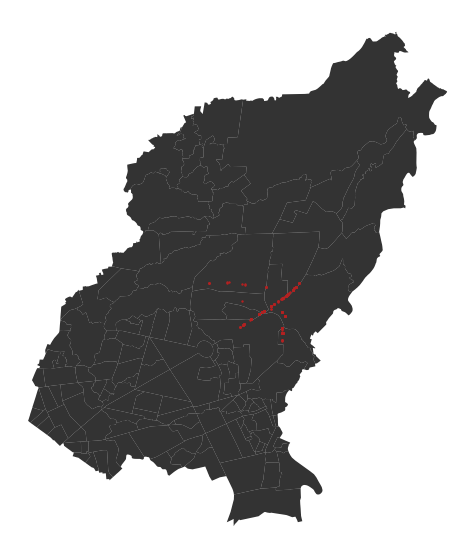

In [16]:
# Choose Best Coverage
# radius = 0.035
radius = 0.025

qc_shp = gpd.read_postgis(
'''
SELECT *
FROM gadm.ph_brgy
WHERE name_2 = 'Quezon City'
'''
,con = conn, geom_col ='geom'
)

qc = qc_shp[['name_2', 'name_3', 'geom']]
qc

pointInPolys2 = sjoin(gdf, qc, how='left')
gdf_qc = pointInPolys2.dropna()

police_qc1 = police_qc.copy()
police_qc1['way'] = police_qc1['way'].buffer(radius)
gdf_qc1 = gdf.loc[gdf.City == 'Quezon City']
police_qc2 = police_qc1.copy()

count_list = []
for i in police_qc2.index:
    point = sjoin(gdf_qc1, police_qc2.loc[[i]], how='left')
    count = point.dropna().shape[0]
    count_list.append(count)
police_qc2['accident_count'] = count_list

police_qc2 = police_qc1.copy()
gdf_qc2 = gdf_qc1.copy()

for i in police_qc2.index:
    point = sjoin(gdf_qc1, police_qc2.loc[[i]], how='left')
    count = point.dropna()
    mask = gdf_qc2[gdf_qc2.index.isin(count.index)].index
    gdf_qc2 = gdf_qc2.drop(index=mask)

fig, ax = plt.subplots(figsize=(10, 10))
qc.plot(ax=ax, alpha=0.8, color='black')
gdf_qc2.plot(ax=ax, color='firebrick', markersize=2)
ax.set_axis_off()
plt.show()

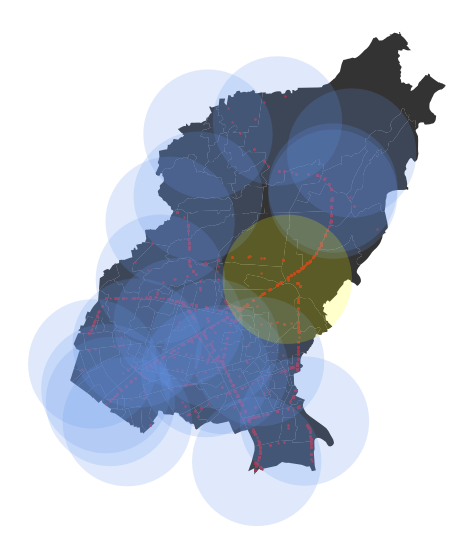

In [19]:
pointInPolys2 = sjoin(gdf, qc, how='left')
gdf_qc = pointInPolys2.dropna()

police_qc1 = police_qc.copy()
police_qc1['way'] = police_qc1['way'].buffer(radius)
gdf_qc1 = gdf.loc[gdf.City == 'Quezon City']

add_police = gpd.GeoDataFrame(pd.DataFrame({'name_2':['Quezon City'],
                'amenity':['police'],
                'name':['Proposed Police Station 1'],
                  'way': [Point(121.070271, 14.664651).buffer(radius)]}),
                              geometry='way')
# 14.664651, 121.070271

police_qc2 = gpd.GeoDataFrame(pd.concat([police_qc1, add_police],
                                        ignore_index=True), geometry='way')

count_list = []
for i in police_qc2.index:
    point = sjoin(gdf_qc1, police_qc2.loc[[i]], how='left')
    count = point.dropna().shape[0]
    count_list.append(count)
police_qc2['accident_count'] = count_list

fig, ax = plt.subplots(figsize=(10, 10))
qc.plot(ax=ax, alpha=0.8, color='black')
gdf_qc1.plot(ax=ax,color='firebrick',markersize=2)
police_qc1.plot(ax=ax,color='cornflowerblue', alpha=0.2)
add_police.plot(ax=ax,color='yellow', alpha=0.2)
ax.set_axis_off()
plt.show()

In [25]:
gdf_qc1

Date      Country         City                  Location  \
1      12/27/2020  Philippines  Quezon City  EDSA EUGENIO LOPEZ DRIVE   
4      12/27/2020  Philippines  Quezon City     EDSA P TUAZON FLYOVER   
5      12/27/2020  Philippines  Quezon City     ORTIGAS AVE EDSA POEA   
8      12/26/2020  Philippines  Quezon City             EDSA SANTOLAN   
9      12/26/2020  Philippines  Quezon City      QUEZON AVE SCTALBANO   
...           ...          ...          ...                       ...   
17300   8/20/2018  Philippines  Quezon City    EDSA ORTIGAS ROBINSONS   
17303   8/20/2018  Philippines  Quezon City              EDSA FARMERS   
17305   8/20/2018  Philippines  Quezon City       C5 ATENEO KATIPUNAN   
17306   8/20/2018  Philippines  Quezon City                 EDSA BONI   
17311   8/20/2018  Philippines  Quezon City         EDSA ERMIN GARCIA   

        Latitude   Longitude                    geometry  
1      14.639692  121.040453  POINT (121.04045 14.63969)  
4      14.616404  121.052548  POINT (121.05255 14.61640)  
5      14.593548  121.058028  POINT (121.05803 14.59355)  
8      14.609768  121.055583  POINT (121.05558 14.60977)  
9      14.641388  121.032974  POINT (121.03297 14.64139)  
...          ...         ...                         ...  
17300  14.592515  121.058225  POINT (121.05822 14.59252)  
17303  14.619717  121.050978  POINT (121.05098 14.61972)  
17305  14.638481  121.074540  POINT (121.07454 14.63848)  
17306  14.638481  121.074540  POINT (121.07454 14.63848)  
17311  14.628035  121.047229  POINT (121.04723 14.62804)  

[8725 rows x 7 columns]

In [23]:
police_qc2

name_2 amenity                                   name  \
0   Quezon City  police    La Loma Police Community Precinct 3   
1   Quezon City  police          Quezon City Police Station 12   
2   Quezon City  police  Quezon City Police Community Precinct   
3   Quezon City  police                                Outpost   
4   Quezon City  police                       Task Force Commo   
5   Quezon City  police           Quezon City Police Station 2   
6   Quezon City  police            Police Community Precinct 1   
7   Quezon City  police                   Kamuning Police Post   
8   Quezon City  police           Quezon City Police Station 1   
9   Quezon City  police   Police Station 6 Sub-Station Payatas   
10  Quezon City  police           Greater Lagro Police Station   
11  Quezon City  police                              Station 2   
12  Quezon City  police       PDEA Special Enforcement Service   
13  Quezon City  police     Quezon Police District - Station 9   
14  Quezon City  police                       Cebu detachment    
15  Quezon City  police                         QCPD station 4   
16  Quezon City  police                     IVM POLICE STATION   
17  Quezon City  police                              Station 3   
18  Quezon City  police      Barangay Community Police Station   
19  Quezon City  police                 QCPD Police Station 10   
20  Quezon City  police              Proposed Police Station 1   

                                                  way  accident_count  
0   POLYGON ((121.02515 14.62237, 121.02503 14.619...             304  
1   POLYGON ((121.10190 14.60983, 121.10178 14.607...            2610  
2   POLYGON ((121.04622 14.66466, 121.04610 14.662...            1074  
3   POLYGON ((121.11287 14.69992, 121.11275 14.697...             394  
4   POLYGON ((121.11287 14.69754, 121.11275 14.695...             428  
5   POLYGON ((121.03729 14.63998, 121.03717 14.637...            1056  
6   POLYGON ((121.02690 14.61740, 121.02678 14.614...             285  
7   POLYGON ((121.06374 14.62857, 121.06362 14.626...            2595  
8   POLYGON ((121.02009 14.63192, 121.01997 14.629...             327  
9   POLYGON ((121.12015 14.71342, 121.12003 14.710...             127  
10  POLYGON ((121.09149 14.72584, 121.09137 14.723...              39  
11  POLYGON ((121.05312 14.64781, 121.05300 14.645...            2054  
12  POLYGON ((121.06712 14.63974, 121.06700 14.637...            2700  
13  POLYGON ((121.08457 14.63281, 121.08445 14.630...            4459  
14  POLYGON ((121.03343 14.60963, 121.03331 14.607...             237  
15  POLYGON ((121.06462 14.72074, 121.06450 14.718...              17  
16  POLYGON ((121.06085 14.69674, 121.06073 14.694...             235  
17  POLYGON ((121.05000 14.68709, 121.04988 14.684...             500  
18  POLYGON ((121.08346 14.59425, 121.08334 14.591...            2495  
19  POLYGON ((121.07082 14.62976, 121.07070 14.627...            3265  
20  POLYGON ((121.09527 14.66465, 121.09515 14.662...            1880

In [26]:
qc

name_2             name_3  \
0    Quezon City             Alicia   
1    Quezon City             Amihan   
2    Quezon City    Apolonio Samson   
3    Quezon City             Aurora   
4    Quezon City              Baesa   
..           ...                ...   
136  Quezon City   Veterans Village   
137  Quezon City  Villa Maria Clara   
138  Quezon City        West Kamias   
139  Quezon City      West Triangle   
140  Quezon City       White Plains   

                                                  geom  
0    MULTIPOLYGON (((121.02535 14.66002, 121.02502 ...  
1    MULTIPOLYGON (((121.06861 14.63062, 121.06787 ...  
2    MULTIPOLYGON (((121.00302 14.64464, 121.00315 ...  
3    MULTIPOLYGON (((121.00730 14.61854, 121.00729 ...  
4    MULTIPOLYGON (((121.00325 14.66466, 121.00394 ...  
..                                                 ...  
136  MULTIPOLYGON (((121.01647 14.65398, 121.01672 ...  
137  MULTIPOLYGON (((121.06507 14.61482, 121.06514 ...  
138  MULTIPOLYGON (((121.04346 14.63058, 121.04439 ...  
139  MULTIPOLYGON (((121.02471 14.64207, 121.02510 ...  
140  MULTIPOLYGON (((121.06690 14.60209, 121.06734 ...  

[141 rows x 3 columns]

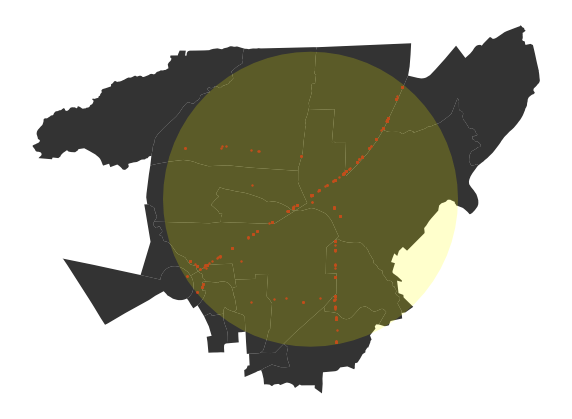

In [58]:
point = sjoin(qc, add_police, how='left')
count = point.dropna()

point1 = sjoin(gdf_qc1, add_police, how='left')
count1 = point1.dropna()

fig, ax = plt.subplots(figsize=(10, 10))
count.plot(ax=ax, alpha=0.8, color='black')
count1.plot(ax=ax,color='firebrick',markersize=2)
add_police.plot(ax=ax,color='yellow', alpha=0.2)
ax.set_axis_off()
plt.show()

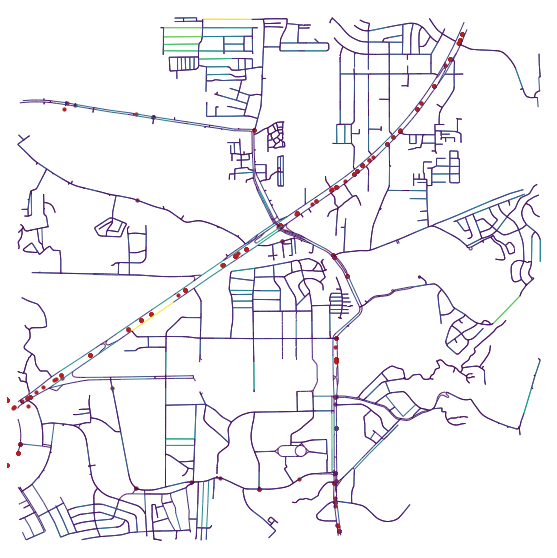

In [57]:
import osmnx as ox
import sqlite3
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx

ox.config(log_file=True, log_console=True, use_cache=True)

fig, ax = plt.subplots(figsize=(10, 10))
police_x = ox.graph_from_point([14.661660, 121.070399], dist=2000, network_type='drive', simplify=False)
edge_color = ox.plot.get_edge_colors_by_attr(police_x, attr = 'length')
count1.plot(ax=ax,color='firebrick', markersize=10)
ox.plot_graph(police_x, edge_color=edge_color, node_size=0, ax=ax)
plt.show()

In [21]:
count_list = []
for i in police_qc2.index:
    point = sjoin(gdf_qc1, add_police.loc[[i]], how='left')
    count = point.dropna().shape[0]
    count_list.append(count)


name_2             name_3  \
0    Quezon City             Alicia   
1    Quezon City             Amihan   
2    Quezon City    Apolonio Samson   
3    Quezon City             Aurora   
4    Quezon City              Baesa   
..           ...                ...   
136  Quezon City   Veterans Village   
137  Quezon City  Villa Maria Clara   
138  Quezon City        West Kamias   
139  Quezon City      West Triangle   
140  Quezon City       White Plains   

                                                  geom  
0    MULTIPOLYGON (((121.02535 14.66002, 121.02502 ...  
1    MULTIPOLYGON (((121.06861 14.63062, 121.06787 ...  
2    MULTIPOLYGON (((121.00302 14.64464, 121.00315 ...  
3    MULTIPOLYGON (((121.00730 14.61854, 121.00729 ...  
4    MULTIPOLYGON (((121.00325 14.66466, 121.00394 ...  
..                                                 ...  
136  MULTIPOLYGON (((121.01647 14.65398, 121.01672 ...  
137  MULTIPOLYGON (((121.06507 14.61482, 121.06514 ...  
138  MULTIPOLYGON (((121.04346 14.63058, 121.04439 ...  
139  MULTIPOLYGON (((121.02471 14.64207, 121.02510 ...  
140  MULTIPOLYGON (((121.06690 14.60209, 121.06734 ...  

[141 rows x 3 columns]

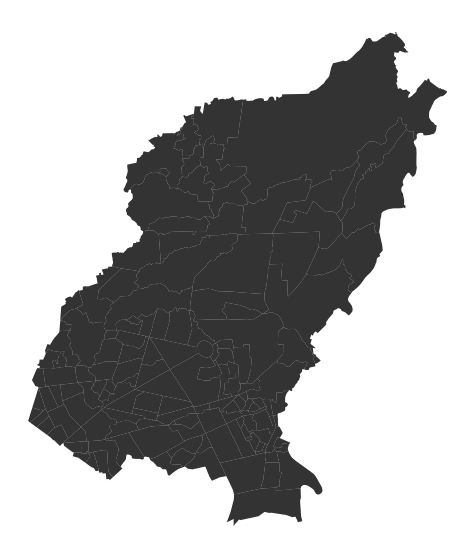

In [20]:
gdf_qc2 = gdf_qc1.copy()

for i in police_qc2.index:
    point = sjoin(gdf_qc1, police_qc2.loc[[i]], how='left')
    count = point.dropna()
    mask = gdf_qc2[gdf_qc2.index.isin(count.index)].index
    gdf_qc2 = gdf_qc2.drop(index=mask)

fig, ax = plt.subplots(figsize=(10, 10))
qc.plot(ax=ax, alpha=0.8, color='black')
gdf_qc2.plot(ax=ax, color='firebrick', markersize=2)
ax.set_axis_off()
plt.show()

### Hospital

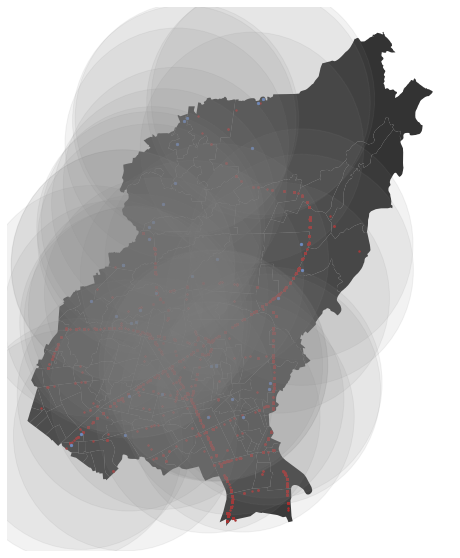

In [42]:
# Check which coverage will cover all accidents
radius = 0.04

q = '''
SELECT g.name_2, p.amenity, p.name, p.way
FROM ph_point as p
JOIN gadm.ph_brgy as g ON st_within(p.way, g.geom)
WHERE p.amenity ~* 'hospital' AND p.name IS NOT NULL AND g.name_2 = 'Quezon City'
'''

hospital_qc = gpd.read_postgis(q, con=conn, geom_col='way')

pointInPolys2 = sjoin(gdf, qc, how='left')
gdf_qc = pointInPolys2.dropna()

fig, ax = plt.subplots(figsize=(10, 10))
qc.plot(ax=ax, alpha=0.8, color='black')
gdf_qc.plot(ax=ax,color='firebrick',markersize=2)
hospital_qc.plot(ax=ax,color='cornflowerblue',markersize=5)
for i in hospital_qc.index:
    cx = hospital_qc.loc[i]['way'].xy[0][0]
    cy = hospital_qc.loc[i]['way'].xy[1][0]
    circle = plt.Circle((cx, cy), radius, alpha=0.2, color='gray')
    ax.add_patch(circle)
ax.set_axis_off()

plt.show()

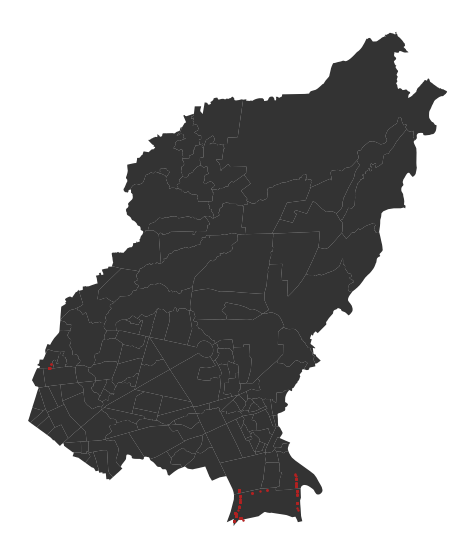

In [17]:
# Choose best coverage
radius = 0.025

hospital_qc1 = hospital_qc.copy()
hospital_qc1['way'] = hospital_qc1['way'].buffer(radius)
gdf_qc1 = gdf.loc[gdf.City == 'Quezon City']
hospital_qc2 = hospital_qc1.copy()

count_list = []
for i in hospital_qc2.index:
    point = sjoin(gdf_qc1, hospital_qc2.loc[[i]], how='left')
    count = point.dropna().shape[0]
    count_list.append(count)
hospital_qc2['accident_count'] = count_list

hospital_qc2 = hospital_qc1.copy()
gdf_qc2 = gdf_qc1.copy()

for i in hospital_qc2.index:
    point = sjoin(gdf_qc1, hospital_qc2.loc[[i]], how='left')
    count = point.dropna()
    mask = gdf_qc2[gdf_qc2.index.isin(count.index)].index
    gdf_qc2 = gdf_qc2.drop(index=mask)

fig, ax = plt.subplots(figsize=(10, 10))
qc.plot(ax=ax, alpha=0.8, color='black')
gdf_qc2.plot(ax=ax, color='firebrick', markersize=2)
ax.set_axis_off()
plt.show()

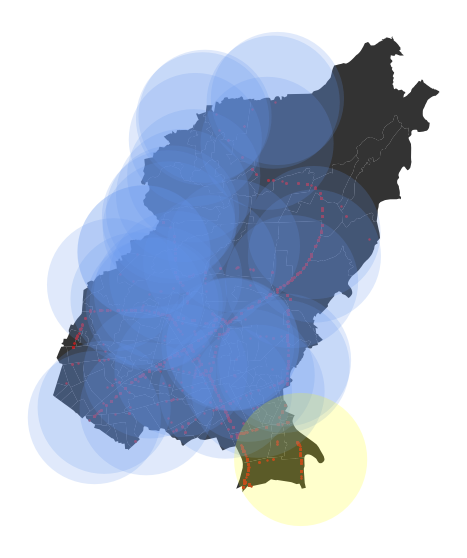

In [18]:
pointInPolys2 = sjoin(gdf, qc, how='left')
gdf_qc = pointInPolys2.dropna()

hospital_qc1 = hospital_qc.copy()
hospital_qc1['way'] = hospital_qc1['way'].buffer(radius)
gdf_qc1 = gdf.loc[gdf.City == 'Quezon City']

add_hospital = gpd.GeoDataFrame(pd.DataFrame({'name_2':['Quezon City'],
                'amenity':['hospital'],
                'name':['Proposed Hospital 1'],
                  'way': [Point(121.07935, 14.60144).buffer(radius)]}),
                              geometry='way')

hospital_qc2 = gpd.GeoDataFrame(pd.concat([hospital_qc1, add_hospital],
                                        ignore_index=True), geometry='way')

count_list = []
for i in hospital_qc2.index:
    point = sjoin(gdf_qc1, hospital_qc2.loc[[i]], how='left')
    count = point.dropna().shape[0]
    count_list.append(count)
hospital_qc2['accident_count'] = count_list

fig, ax = plt.subplots(figsize=(10, 10))
qc.plot(ax=ax, alpha=0.8, color='black')
gdf_qc1.plot(ax=ax,color='firebrick',markersize=2)
hospital_qc1.plot(ax=ax,color='cornflowerblue', alpha=0.2)
add_hospital.plot(ax=ax,color='yellow', alpha=0.2)
ax.set_axis_off()
plt.show()

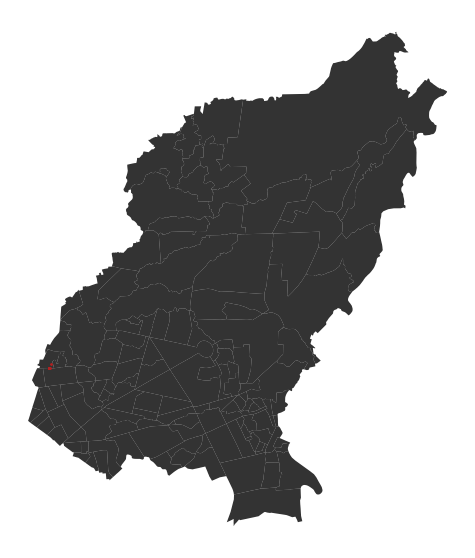

In [19]:
gdf_qc2 = gdf_qc1.copy()

for i in hospital_qc2.index:
    point = sjoin(gdf_qc1, hospital_qc2.loc[[i]], how='left')
    count = point.dropna()
    mask = gdf_qc2[gdf_qc2.index.isin(count.index)].index
    gdf_qc2 = gdf_qc2.drop(index=mask)

fig, ax = plt.subplots(figsize=(10, 10))
qc.plot(ax=ax, alpha=0.8, color='black')
gdf_qc2.plot(ax=ax, color='firebrick', markersize=2)
ax.set_axis_off()
plt.show()

## Mandaluyong

### Police

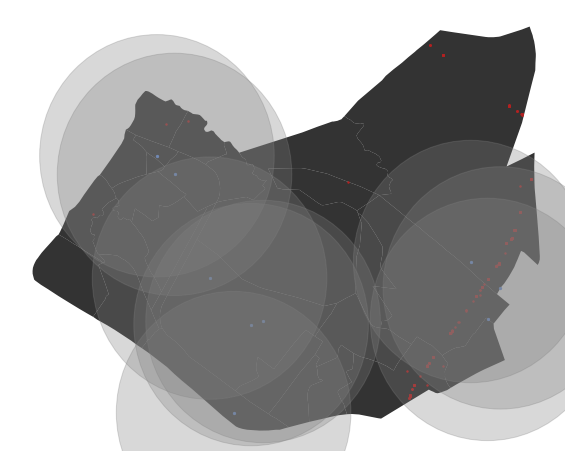

In [20]:
# Check which coverage will cover all accidents
radius = 0.01

q = '''
SELECT g.name_2, p.amenity, p.name, p.way
FROM ph_point as p
JOIN gadm.ph_brgy as g ON st_within(p.way, g.geom)
WHERE p.amenity ~* 'police' AND p.name IS NOT NULL AND g.name_2 = 'Mandaluyong'
'''

police_manda = gpd.read_postgis(q, con=conn, geom_col='way')

manda_shp = gpd.read_postgis(
'''
SELECT *
FROM gadm.ph_brgy
WHERE name_2 = 'Mandaluyong'
'''
,con = conn, geom_col ='geom'
)

manda = manda_shp[['name_2', 'name_3', 'geom']]

pointInPolys2 = sjoin(gdf, manda, how='left')
gdf_manda = pointInPolys2.dropna()

fig, ax = plt.subplots(figsize=(10, 10))
manda.plot(ax=ax, alpha=0.8, color='black')
gdf_manda.plot(ax=ax,color='firebrick',markersize=2)
police_manda.plot(ax=ax,color='cornflowerblue',markersize=5)
for i in police_manda.index:
    cx = police_manda.loc[i]['way'].xy[0][0]
    cy = police_manda.loc[i]['way'].xy[1][0]
    circle = plt.Circle((cx, cy), radius, alpha=0.3, color='gray')
    ax.add_patch(circle)
ax.set_axis_off()

plt.show()

In [21]:
police_manda1 = police_manda.copy()
police_manda1['way'] = police_manda1['way'].buffer(radius)
gdf_manda1 = gdf.loc[gdf.City == 'Mandaluyong']

count_list = []
for i in police_manda1.index:
    point = sjoin(gdf_manda1, police_manda1.loc[[i]], how='left')
    count = point.dropna().shape[0]
    count_list.append(count)
police_manda1['accident_count'] = count_list
police_manda1

name_2 amenity                                     name  \
0  Mandaluyong  police  Mandaluyong Police Community Precinct 5   
1  Mandaluyong  police                                    Pcp-1   
2  Mandaluyong  police  Mandaluyong Police Community Precinct 1   
3  Mandaluyong  police  Mandaluyong Police Community Precinct 2   
4  Mandaluyong  police                    BJMP Mandaluyong City   
5  Mandaluyong  police    Mandaluyong City Traffic Headquarters   
6  Mandaluyong  police              Police Community Precinct 2   
7  Mandaluyong  police             Mandaluyong MPU/STMRU Office   
8  Mandaluyong  police                        Mandaluyong PCP 4   

                                                 way  accident_count  
0  POLYGON ((121.06353 14.57782, 121.06348 14.576...            2778  
1  POLYGON ((121.03684 14.58979, 121.03680 14.588...               3  
2  POLYGON ((121.03534 14.59133, 121.03530 14.590...               3  
3  POLYGON ((121.04188 14.57014, 121.04183 14.569...               0  
4  POLYGON ((121.04337 14.57740, 121.04332 14.576...               0  
5  POLYGON ((121.04439 14.57765, 121.04434 14.576...               0  
6  POLYGON ((121.03983 14.58123, 121.03978 14.580...               0  
7  POLYGON ((121.06209 14.58260, 121.06205 14.581...            2652  
8  POLYGON ((121.06463 14.58043, 121.06458 14.579...            2653

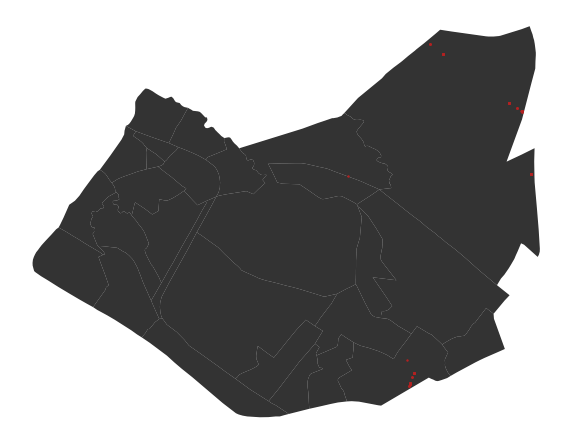

In [22]:
# Choose Optimal Coverage
radius = 0.008

pointInPolys2 = sjoin(gdf, manda, how='left')
gdf_manda = pointInPolys2.dropna()

police_manda1 = police_manda.copy()
police_manda1['way'] = police_manda1['way'].buffer(radius)
gdf_manda1 = gdf.loc[gdf.City == 'Mandaluyong']
police_manda2 = police_manda1.copy()

count_list = []
for i in police_manda2.index:
    point = sjoin(gdf_manda1, police_manda2.loc[[i]], how='left')
    count = point.dropna().shape[0]
    count_list.append(count)
police_manda2['accident_count'] = count_list

police_manda2 = police_manda1.copy()
gdf_manda2 = gdf_manda1.copy()

for i in police_manda2.index:
    point = sjoin(gdf_manda2, police_manda2.loc[[i]], how='left')
    count = point.dropna()
    mask = gdf_manda2[gdf_manda2.index.isin(count.index)].index
    gdf_manda2 = gdf_manda2.drop(index=mask)

fig, ax = plt.subplots(figsize=(10, 10))
manda.plot(ax=ax, alpha=0.8, color='black')
gdf_manda2.plot(ax=ax, color='firebrick', markersize=2)
ax.set_axis_off()
plt.show()

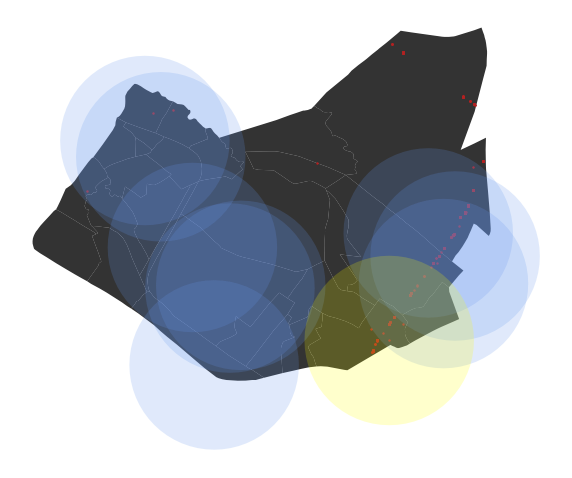

In [23]:
pointInPolys2 = sjoin(gdf, manda, how='left')
gdf_manda = pointInPolys2.dropna()

police_manda1 = police_manda.copy()
police_manda1['way'] = police_manda1['way'].buffer(radius)
gdf_manda1 = gdf.loc[gdf.City == 'Mandaluyong']

add_police = gpd.GeoDataFrame(pd.DataFrame({'name_2':['Mandaluyong'],
                'amenity':['police'],
                'name':['Proposed Police Station 1'],
                  'way': [Point(121.04841, 14.57245).buffer(radius)]}), geometry='way')

police_manda2 = gpd.GeoDataFrame(pd.concat([police_manda1, add_police],
                                           ignore_index=True), geometry='way')

count_list = []
for i in police_manda2.index:
    point = sjoin(gdf_manda1, police_manda2.loc[[i]], how='left')
    count = point.dropna().shape[0]
    count_list.append(count)
police_manda2['accident_count'] = count_list

fig, ax = plt.subplots(figsize=(10, 10))
manda.plot(ax=ax, alpha=0.8, color='black')
gdf_manda1.plot(ax=ax,color='firebrick',markersize=2)
police_manda1.plot(ax=ax,color='cornflowerblue', alpha=0.2)
add_police.plot(ax=ax,color='yellow', alpha=0.2)
ax.set_axis_off()
plt.show()

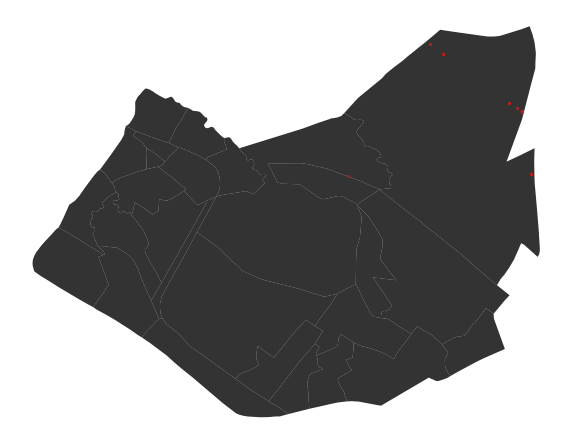

In [24]:
gdf_manda2 = gdf_manda1.copy()

for i in police_manda2.index:
    point = sjoin(gdf_manda1, police_manda2.loc[[i]], how='left')
    count = point.dropna()
    mask = gdf_manda2[gdf_manda2.index.isin(count.index)].index
    gdf_manda2 = gdf_manda2.drop(index=mask)

fig, ax = plt.subplots(figsize=(10, 10))
manda.plot(ax=ax, alpha=0.8, color='black')
gdf_manda2.plot(ax=ax, color='firebrick', markersize=2)
ax.set_axis_off()
plt.show()

### Hospital

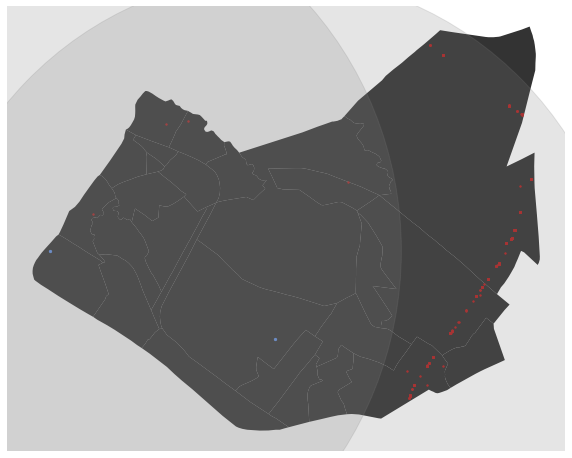

In [25]:
# Check which coverage will cover all accidents
radius = 0.03

q = '''
SELECT g.name_2, p.amenity, p.name, p.way
FROM ph_point as p
JOIN gadm.ph_brgy as g ON st_within(p.way, g.geom)
WHERE p.amenity ~* 'hospital' AND p.name IS NOT NULL AND g.name_2 = 'Mandaluyong'
'''

hospital_manda = gpd.read_postgis(q, con=conn, geom_col='way')

pointInPolys2 = sjoin(gdf, manda, how='left')
gdf_manda = pointInPolys2.dropna()

fig, ax = plt.subplots(figsize=(10, 10))
manda.plot(ax=ax, alpha=0.8, color='black')
gdf_manda.plot(ax=ax,color='firebrick',markersize=2)
hospital_manda.plot(ax=ax,color='cornflowerblue',markersize=5)
for i in hospital_manda.index:
    cx = hospital_manda.loc[i]['way'].xy[0][0]
    cy = hospital_manda.loc[i]['way'].xy[1][0]
    circle = plt.Circle((cx, cy), radius, alpha=0.2, color='gray')
    ax.add_patch(circle)
ax.set_axis_off()

plt.show()

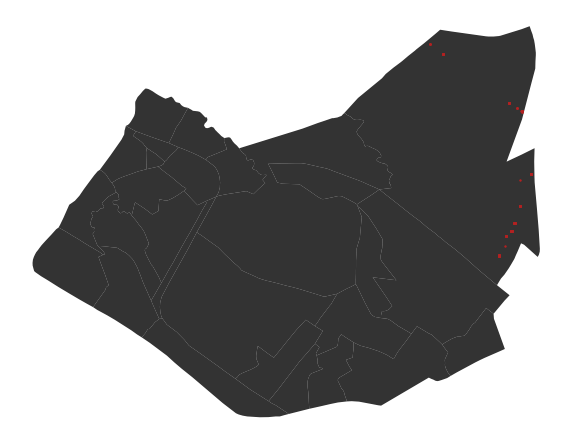

In [26]:
# Choose Optimal Coverage
radius = 0.02

hospital_manda1 = hospital_manda.copy()
hospital_manda1['way'] = hospital_manda1['way'].buffer(radius)
gdf_manda1 = gdf.loc[gdf.City == 'Mandaluyong']
hospital_manda2 = hospital_manda1.copy()

count_list = []
for i in hospital_manda2.index:
    point = sjoin(gdf_manda1, hospital_manda2.loc[[i]], how='left')
    count = point.dropna().shape[0]
    count_list.append(count)
hospital_manda2['accident_count'] = count_list

hospital_manda2 = hospital_manda1.copy()
gdf_manda2 = gdf_manda1.copy()

for i in hospital_manda2.index:
    point = sjoin(gdf_manda1, hospital_manda2.loc[[i]], how='left')
    count = point.dropna()
    mask = gdf_manda2[gdf_manda2.index.isin(count.index)].index
    gdf_manda2 = gdf_manda2.drop(index=mask)

fig, ax = plt.subplots(figsize=(10, 10))
manda.plot(ax=ax, alpha=0.8, color='black')
gdf_manda2.plot(ax=ax, color='firebrick', markersize=2)
ax.set_axis_off()
plt.show()

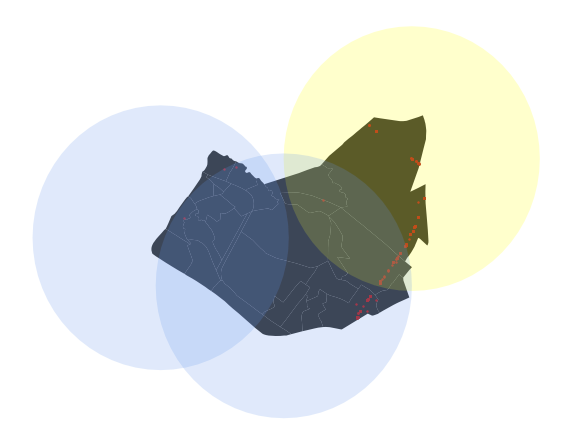

In [27]:
pointInPolys2 = sjoin(gdf, manda, how='left')
gdf_manda = pointInPolys2.dropna()

hospital_manda1 = hospital_manda.copy()
hospital_manda1['way'] = hospital_manda1['way'].buffer(radius)
gdf_manda1 = gdf.loc[gdf.City == 'Mandaluyong']

add_hospital = gpd.GeoDataFrame(pd.DataFrame({'name_2':['Mandaluyong'],
                'amenity':['hospital'],
                'name':['Proposed Hospital 1'],
                  'way': [Point(121.05538, 14.59545).buffer(radius)]}),
                              geometry='way')

hospital_manda2 = gpd.GeoDataFrame(pd.concat([hospital_manda1, add_hospital],
                                        ignore_index=True), geometry='way')

count_list = []
for i in hospital_manda2.index:
    point = sjoin(gdf_manda1, hospital_manda2.loc[[i]], how='left')
    count = point.dropna().shape[0]
    count_list.append(count)
hospital_manda2['accident_count'] = count_list

fig, ax = plt.subplots(figsize=(10, 10))
manda.plot(ax=ax, alpha=0.8, color='black')
gdf_manda1.plot(ax=ax,color='firebrick',markersize=2)
add_hospital.plot(ax=ax,color='yellow', alpha=0.2)
hospital_manda1.plot(ax=ax, color='cornflowerblue', alpha=0.2)
ax.set_axis_off()
plt.show()

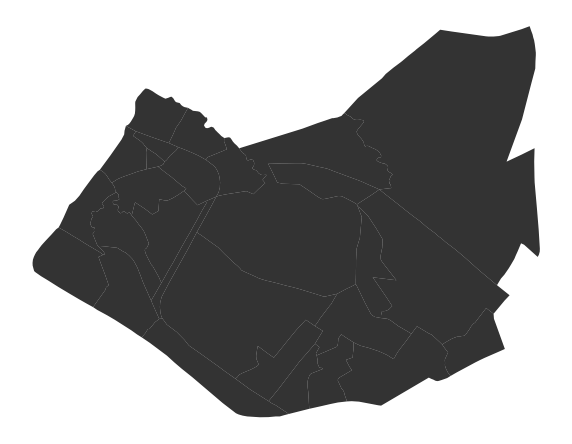

In [28]:
gdf_manda2 = gdf_manda1.copy()

for i in hospital_manda2.index:
    point = sjoin(gdf_manda1, hospital_manda2.loc[[i]], how='left')
    count = point.dropna()
    mask = gdf_manda2[gdf_manda2.index.isin(count.index)].index
    gdf_manda2 = gdf_manda2.drop(index=mask)

fig, ax = plt.subplots(figsize=(10, 10))
manda.plot(ax=ax, alpha=0.8, color='black')
gdf_manda2.plot(ax=ax, color='firebrick', markersize=2)
ax.set_axis_off()
plt.show()

## Makati

### Police

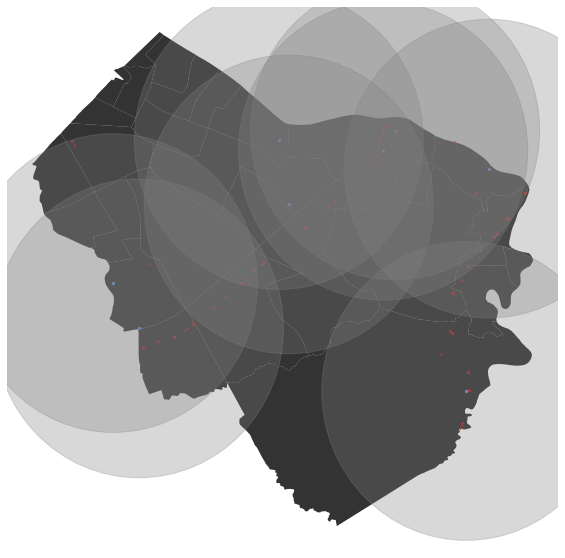

In [29]:
# Check which coverage will cover all accidents
radius = 0.02

q = '''
SELECT g.name_2, p.amenity, p.name, p.way
FROM ph_point as p
JOIN gadm.ph_brgy as g ON st_within(p.way, g.geom)
WHERE p.amenity ~* 'police' AND p.name IS NOT NULL AND g.name_2 = 'Makati City'
'''

police_makati = gpd.read_postgis(q, con=conn, geom_col='way')

makati_shp = gpd.read_postgis(
'''
SELECT *
FROM gadm.ph_brgy
WHERE name_2 = 'Makati City'
'''
,con = conn, geom_col ='geom'
)

makati = makati_shp[['name_2', 'name_3', 'geom']]

pointInPolys2 = sjoin(gdf, makati, how='left')
gdf_makati = pointInPolys2.dropna()

fig, ax = plt.subplots(figsize=(10, 10))
makati.plot(ax=ax, alpha=0.8, color='black')
gdf_makati.plot(ax=ax,color='firebrick',markersize=2)
police_makati.plot(ax=ax,color='cornflowerblue',markersize=5)
for i in police_makati.index:
    cx = police_makati.loc[i]['way'].xy[0][0]
    cy = police_makati.loc[i]['way'].xy[1][0]
    circle = plt.Circle((cx, cy), radius, alpha=0.3, color='gray')
    ax.add_patch(circle)
ax.set_axis_off()

plt.show()

In [30]:
police_makati1 = police_makati.copy()
police_makati1['way'] = police_makati1['way'].buffer(radius)
gdf_makati1 = gdf.loc[gdf.City == 'Makati City']

count_list = []
for i in police_makati1.index:
    point = sjoin(gdf_makati1, police_makati1.loc[[i]], how='left')
    count = point.dropna().shape[0]
    count_list.append(count)
police_makati1['accident_count'] = count_list
police_makati1

name_2 amenity                         name  \
0  Makati City  police                       Pcp- 3   
1  Makati City  police                       Pcp- 5   
2  Makati City  police  PNP Internal Affair Service   
3  Makati City  police               Detachment PNP   
4  Makati City  police                       Pcp- 2   
5  Makati City  police                        Pcp-9   
6  Makati City  police                        PCP-8   
7  Makati City  police   Makati Police Precinct № 7   

                                                 way  accident_count  
0  POLYGON ((121.03200 14.54142, 121.03190 14.539...             712  
1  POLYGON ((121.02842 14.54749, 121.02832 14.545...             362  
2  POLYGON ((121.05273 14.55802, 121.05263 14.556...            1560  
3  POLYGON ((121.06743 14.56791, 121.06734 14.565...            1457  
4  POLYGON ((121.06579 14.56520, 121.06569 14.563...            1505  
5  POLYGON ((121.05136 14.56663, 121.05126 14.564...            1554  
6  POLYGON ((121.07729 14.53304, 121.07720 14.531...             259  
7  POLYGON ((121.08040 14.56280, 121.08030 14.560...            1161

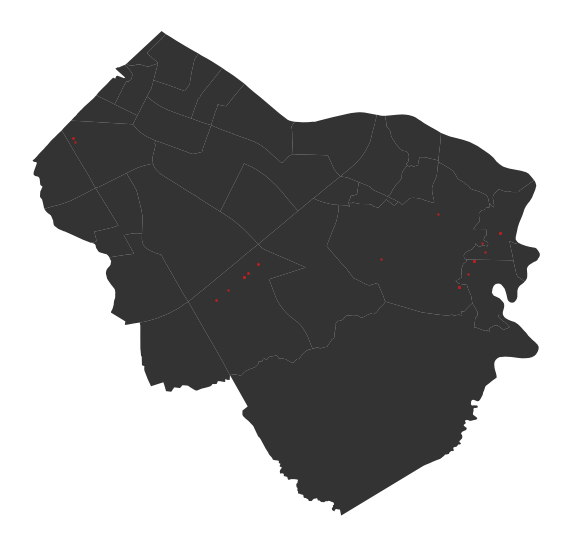

In [31]:
# Choose best coverage
radius = 0.009

pointInPolys2 = sjoin(gdf, makati, how='left')
gdf_makati = pointInPolys2.dropna()

police_makati1 = police_makati.copy()
police_makati1['way'] = police_makati1['way'].buffer(radius)
gdf_makati1 = gdf.loc[gdf.City == 'Makati City']
police_makati2 = police_makati1.copy()

count_list = []
for i in police_makati2.index:
    point = sjoin(gdf_makati1, police_makati2.loc[[i]], how='left')
    count = point.dropna().shape[0]
    count_list.append(count)
police_makati2['accident_count'] = count_list

police_makati2 = police_makati1.copy()
gdf_makati2 = gdf_makati1.copy()

for i in police_makati2.index:
    point = sjoin(gdf_makati2, police_makati2.loc[[i]], how='left')
    count = point.dropna()
    mask = gdf_makati2[gdf_makati2.index.isin(count.index)].index
    gdf_makati2 = gdf_makati2.drop(index=mask)

fig, ax = plt.subplots(figsize=(10, 10))
makati.plot(ax=ax, alpha=0.8, color='black')
gdf_makati2.plot(ax=ax, color='firebrick', markersize=2)
ax.set_axis_off()
plt.show()

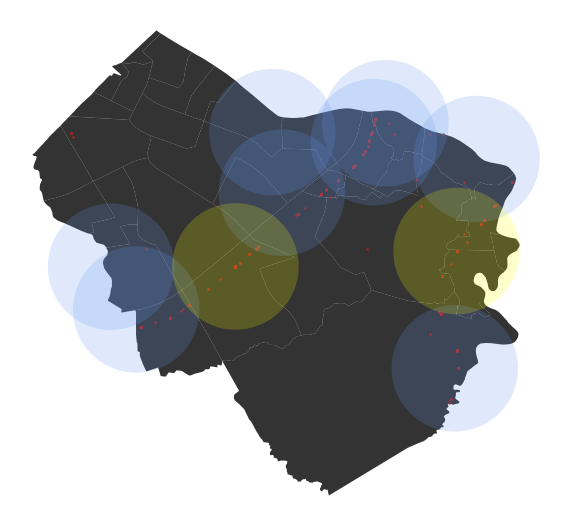

In [32]:
pointInPolys2 = sjoin(gdf, makati, how='left')
gdf_makati = pointInPolys2.dropna()

police_makati1 = police_makati.copy()
police_makati1['way'] = police_makati1['way'].buffer(radius)
gdf_makati1 = gdf.loc[gdf.City == 'Makati City']

add_police = gpd.GeoDataFrame(pd.DataFrame({'name_2':['Makati City', 'Makati City'],
                'amenity':['police', 'police'],
                'name':['Proposed Police Station 1', 'Proposed Police Station 2'],
                  'way': [Point(121.05755, 14.54972).buffer(radius),
                          Point(121.02611, 14.54753).buffer(radius)]}), geometry='way')

police_makati2 = gpd.GeoDataFrame(pd.concat([police_makati1, add_police],
                                           ignore_index=True), geometry='way')

count_list = []
for i in police_makati2.index:
    point = sjoin(gdf_makati1, police_makati2.loc[[i]], how='left')
    count = point.dropna().shape[0]
    count_list.append(count)
police_makati2['accident_count'] = count_list

fig, ax = plt.subplots(figsize=(10, 10))
makati.plot(ax=ax, alpha=0.8, color='black')
gdf_makati1.plot(ax=ax,color='firebrick',markersize=2)
police_makati1.plot(ax=ax,color='cornflowerblue', alpha=0.2)
add_police.plot(ax=ax,color='yellow', alpha=0.2)
ax.set_axis_off()
plt.show()

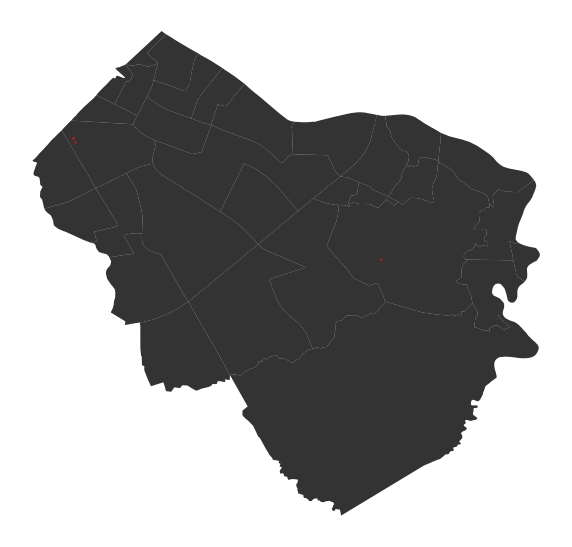

In [33]:
gdf_makati2 = gdf_makati1.copy()

for i in police_makati2.index:
    point = sjoin(gdf_makati1, police_makati2.loc[[i]], how='left')
    count = point.dropna()
    mask = gdf_makati2[gdf_makati2.index.isin(count.index)].index
    gdf_makati2 = gdf_makati2.drop(index=mask)

fig, ax = plt.subplots(figsize=(10, 10))
makati.plot(ax=ax, alpha=0.8, color='black')
gdf_makati2.plot(ax=ax, color='firebrick', markersize=2)
ax.set_axis_off()
plt.show()

### Hospital

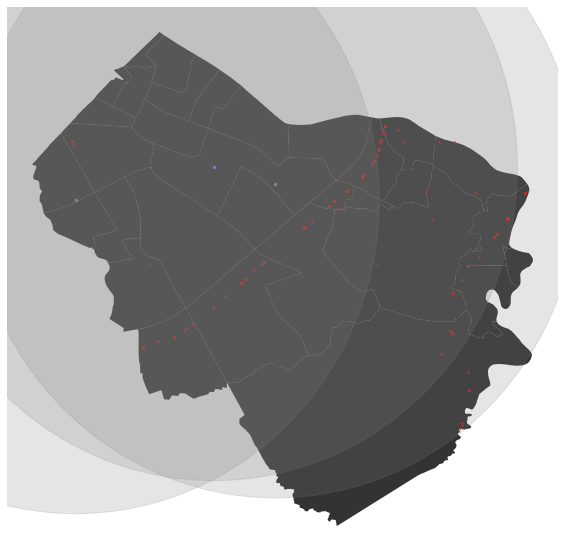

In [34]:
# Check which coverage will cover all accidents
radius = 0.042

q = '''
SELECT g.name_2, p.amenity, p.name, p.way
FROM ph_point as p
JOIN gadm.ph_brgy as g ON st_within(p.way, g.geom)
WHERE p.amenity ~* 'hospital' AND p.name IS NOT NULL AND g.name_2 = 'Makati City'
'''

hospital_makati = gpd.read_postgis(q, con=conn, geom_col='way')

pointInPolys2 = sjoin(gdf, makati, how='left')
gdf_makati = pointInPolys2.dropna()

fig, ax = plt.subplots(figsize=(10, 10))
makati.plot(ax=ax, alpha=0.8, color='black')
gdf_makati.plot(ax=ax,color='firebrick',markersize=2)
hospital_makati.plot(ax=ax,color='cornflowerblue',markersize=5)
for i in hospital_makati.index:
    cx = hospital_makati.loc[i]['way'].xy[0][0]
    cy = hospital_makati.loc[i]['way'].xy[1][0]
    circle = plt.Circle((cx, cy), radius, alpha=0.2, color='gray')
    ax.add_patch(circle)
ax.set_axis_off()

plt.show()

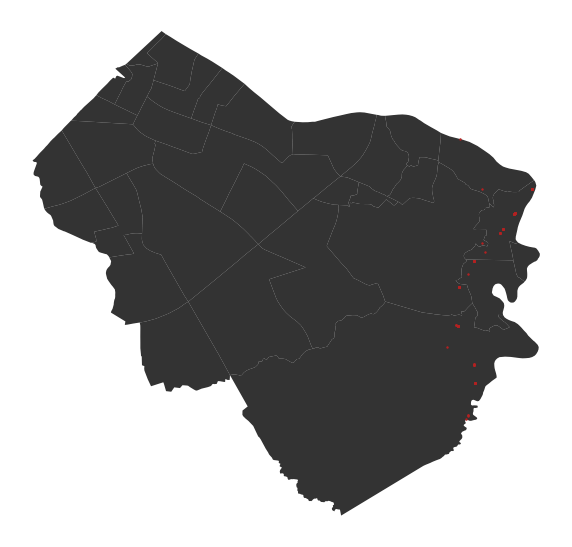

In [35]:
# Choose best coverage
radius = 0.025

hospital_makati1 = hospital_makati.copy()
hospital_makati1['way'] = hospital_makati1['way'].buffer(radius)
gdf_makati1 = gdf.loc[gdf.City == 'Makati City']
hospital_makati2 = hospital_makati1.copy()

count_list = []
for i in hospital_makati2.index:
    point = sjoin(gdf_makati1, hospital_makati2.loc[[i]], how='left')
    count = point.dropna().shape[0]
    count_list.append(count)
hospital_makati2['accident_count'] = count_list

hospital_makati2 = hospital_makati1.copy()
gdf_makati2 = gdf_makati1.copy()

for i in hospital_makati2.index:
    point = sjoin(gdf_makati1, hospital_makati2.loc[[i]], how='left')
    count = point.dropna()
    mask = gdf_makati2[gdf_makati2.index.isin(count.index)].index
    gdf_makati2 = gdf_makati2.drop(index=mask)

fig, ax = plt.subplots(figsize=(10, 10))
makati.plot(ax=ax, alpha=0.8, color='black')
gdf_makati2.plot(ax=ax, color='firebrick', markersize=2)
ax.set_axis_off()
plt.show()

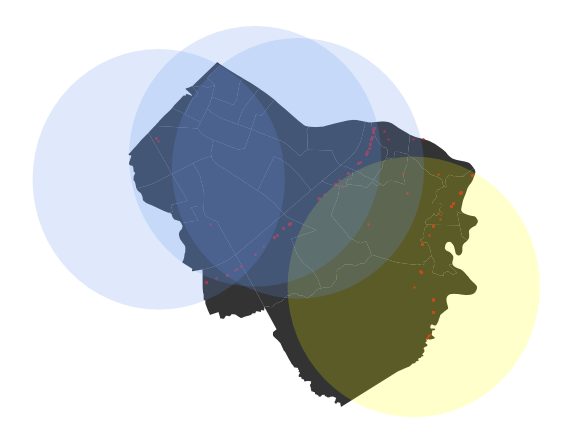

In [36]:
pointInPolys2 = sjoin(gdf, makati, how='left')
gdf_makati = pointInPolys2.dropna()

hospital_makati1 = hospital_makati.copy()
hospital_makati1['way'] = hospital_makati1['way'].buffer(radius)
gdf_makati1 = gdf.loc[gdf.City == 'Makati City']

# Add hospital location
add_hospital = gpd.GeoDataFrame(pd.DataFrame({'name_2':['Makati City'],
                'amenity':['hospital'],
                'name':['Proposed Hospital 1'],
                  'way': [Point(121.05380, 14.53798).buffer(radius)]}),
                              geometry='way')

hospital_makati2 = gpd.GeoDataFrame(pd.concat([hospital_makati1, add_hospital],
                                        ignore_index=True), geometry='way')

count_list = []
for i in hospital_makati2.index:
    point = sjoin(gdf_makati1, hospital_makati2.loc[[i]], how='left')
    count = point.dropna().shape[0]
    count_list.append(count)
hospital_makati2['accident_count'] = count_list

fig, ax = plt.subplots(figsize=(10, 10))
makati.plot(ax=ax, alpha=0.8, color='black')
gdf_makati1.plot(ax=ax,color='firebrick',markersize=2)
add_hospital.plot(ax=ax,color='yellow', alpha=0.2)
hospital_makati1.plot(ax=ax, color='cornflowerblue', alpha=0.2)
ax.set_axis_off()
plt.show()

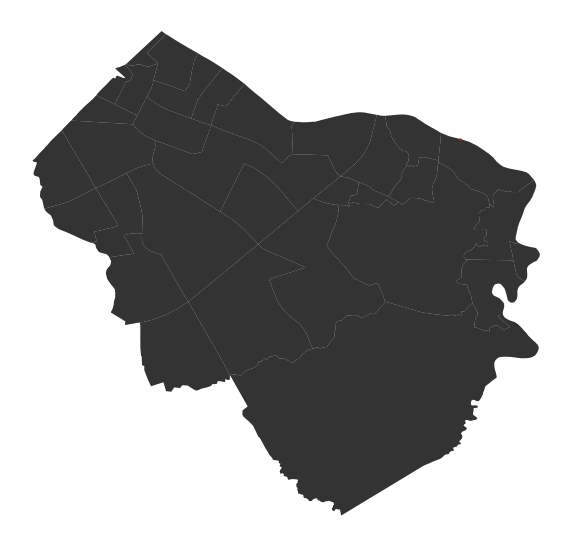

In [37]:
gdf_makati2 = gdf_makati1.copy()

for i in hospital_makati2.index:
    point = sjoin(gdf_makati1, hospital_makati2.loc[[i]], how='left')
    count = point.dropna()
    mask = gdf_makati2[gdf_makati2.index.isin(count.index)].index
    gdf_makati2 = gdf_makati2.drop(index=mask)

fig, ax = plt.subplots(figsize=(10, 10))
makati.plot(ax=ax, alpha=0.8, color='black')
gdf_makati2.plot(ax=ax, color='firebrick', markersize=2)
ax.set_axis_off()
plt.show()

## NCR Hospital

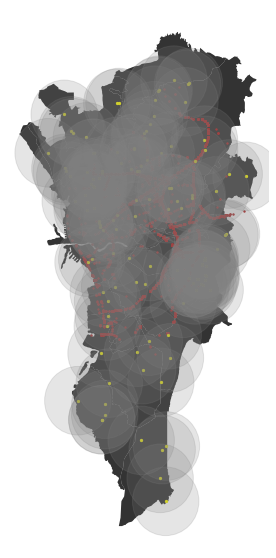

In [38]:
radius = 0.03

q = '''
SELECT g.name_2, p.amenity, p.name, p.way
FROM ph_point as p
JOIN gadm.ph_brgy as g ON st_within(p.way, g.geom)
WHERE p.amenity ~* 'hospital' AND p.name IS NOT NULL AND g.name_1 = 'Metropolitan Manila'
'''

hospital = gpd.read_postgis(q, con=conn, geom_col='way')

fig, ax = plt.subplots(figsize=(10, 10))
ncr.plot(ax=ax, alpha=0.8, color='black')
gdf.plot(ax=ax,color='firebrick',markersize=2)
hospital.plot(ax=ax,color='yellow',markersize=5)
for i in hospital.index:
    cx = hospital.loc[i]['way'].xy[0][0]
    cy = hospital.loc[i]['way'].xy[1][0]
    circle = plt.Circle((cx, cy), radius, alpha=0.2, color='gray')
    ax.add_patch(circle)
ax.set_axis_off()

plt.show()

hospital1 = hospital.copy()
hospital1['way'] = hospital1['way'].buffer(radius)
gdf_ncr = gdf.copy()

hospital2 = hospital1.copy()
count_list = []
for i in hospital1.index:
    point = sjoin(gdf_ncr, hospital1.loc[[i]], how='left')
    count = point.dropna().shape[0]
    count_list.append(count)
hospital2['accident_count'] = count_list

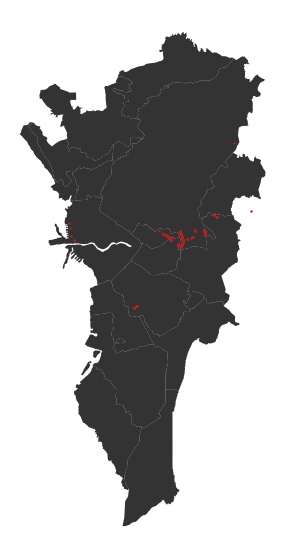

In [39]:
# Choose best coverage
radius = 0.02

hospital1 = hospital.copy()
hospital1['way'] = hospital1['way'].buffer(radius)
gdf_ncr1 = gdf.copy()
hospital2 = hospital1.copy()

count_list = []
for i in hospital2.index:
    point = sjoin(gdf_ncr1, hospital2.loc[[i]], how='left')
    count = point.dropna().shape[0]
    count_list.append(count)
hospital2['accident_count'] = count_list

hospital2 = hospital1.copy()
gdf_ncr2 = gdf_ncr1.copy()

for i in hospital2.index:
    point = sjoin(gdf_ncr1, hospital2.loc[[i]], how='left')
    count = point.dropna()
    mask = gdf_ncr2[gdf_ncr2.index.isin(count.index)].index
    gdf_ncr2 = gdf_ncr2.drop(index=mask)

fig, ax = plt.subplots(figsize=(10, 10))
ncr.plot(ax=ax, alpha=0.8, color='black')
gdf_ncr2.plot(ax=ax, color='firebrick', markersize=2)
ax.set_axis_off()
plt.show()

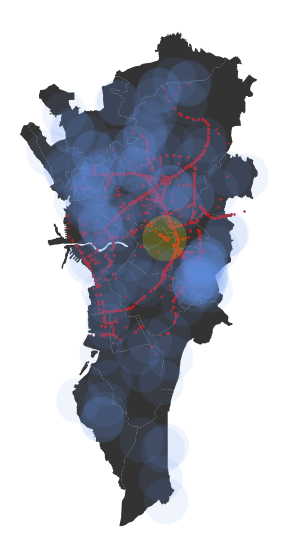

In [40]:
hospital1 = hospital.copy()
hospital1['way'] = hospital1['way'].buffer(radius)

# Add hospital location
add_hospital = gpd.GeoDataFrame(pd.DataFrame({'name_2':['San Juan'],
                'amenity':['hospital'],
                'name':['Proposed Hospital 1'],
                  'way': [Point(121.047888, 14.601078).buffer(radius)]}),
                              geometry='way')

hospital2 = gpd.GeoDataFrame(pd.concat([hospital1, add_hospital],
                                        ignore_index=True), geometry='way')

count_list = []
for i in hospital2.index:
    point = sjoin(gdf, hospital2.loc[[i]], how='left')
    count = point.dropna().shape[0]
    count_list.append(count)
hospital2['accident_count'] = count_list

fig, ax = plt.subplots(figsize=(10, 10))
ncr.plot(ax=ax, alpha=0.8, color='black')
gdf_ncr.plot(ax=ax,color='firebrick',markersize=2)
add_hospital.plot(ax=ax,color='yellow', alpha=0.2)
hospital1.plot(ax=ax, color='cornflowerblue', alpha=0.1)
ax.set_axis_off()
plt.show()

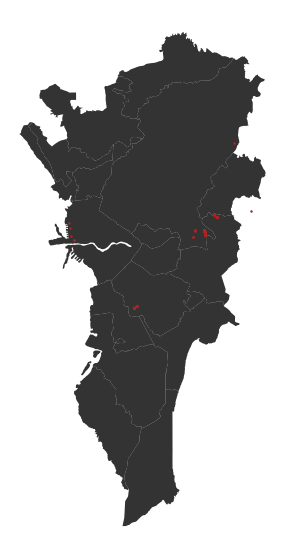

In [41]:
gdf_ncr2 = gdf_ncr1.copy()

for i in hospital2.index:
    point = sjoin(gdf_ncr1, hospital2.loc[[i]], how='left')
    count = point.dropna()
    mask = gdf_ncr2[gdf_ncr2.index.isin(count.index)].index
    gdf_ncr2 = gdf_ncr2.drop(index=mask)

fig, ax = plt.subplots(figsize=(10, 10))
ncr.plot(ax=ax, alpha=0.8, color='black')
gdf_ncr2.plot(ax=ax, color='firebrick', markersize=2)
ax.set_axis_off()
plt.show()